<a href="https://colab.research.google.com/github/JohannKaspar/ml4ia_ss2024/blob/main/exercise_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction

In the last exercises, you implemented different networks for image classification on the CIFAR10 Dataset.
For this exercise you will work on pixelwise instance segmentation (think: classification per pixel instead of per image).

## Grading

You can get a maximum of 50 points.

| Section | Part                  | Task                          | Points |
|---------|-----------------------|-------------------------------|--------|
| 1       | Receptive Field       | Implementation                | 25     |
|         |                       | Quest                         | 5      |
| 2       | Instance Segmentation | Define losses and activations | 10     |
|         |                       | Benchmark                     | 5      |
|         |                       | Question 2                    | 5      |
|         | Total Points          |                               | 50     |

## General Information

**Workflow** For this assignment you need a GPU. If you have one, you can keep on working locally with this notebook. If not, we recommend to use colab. If both options do not work for you, please let us know.

**Assignment submission** You need to submit both this notebook and the model(s) you've trained. If the model is small enough you can submit it via moodle, otherwise upload it e.g. on google drive or firefox send and submit a text file with the link to it.

## How to setup Google Colab

You already know about colab from the previous exercises. Here are the most important infos again:

**Requirements** To use Colab, you must have a Google account with an associated Google Drive.

**Reminder** Ressources on colab are not guaranteed and therefore there might be times where some ressources cannot get allocated. If you're idle for 90 minutes or your connection time exceeds the maximum of 12 hours, the colab virtual machine will disconnect. This means that unsaved progress such as model parameters are lost.

**Upload the data**
You need to upload your data on the remote machine. Make sure to upload the zip and not the extracted data, this is significantly faster. There are two primary options:  
You can upload the data directly into colab (Click on the Files icon on the left side and then on upload). This is the most straightforward way, but you have to do it every time you start a new colab session.  
The second option is to use Google Drive and import the data from there into Colab.
First, you need to upload the provided zip file (data.zip) to your Google Drive. Next, you mount your Google Drive on the remote machine. In order to do so, you can use the cell below.  
In all case you then have to execute the "extract data" cell to unpack the zip file (You might have to change the path_to_zip variable).  
Use the "verify" cell to make sure that the data is accessible.

In [1]:
import os

#### DO NOT DELETE THIS COMMENT ####
from google.colab import drive

### mount your google drive
drive.mount('/content/drive')

# add your local project folder to be able to import all utils files
path = "/content/drive/My Drive/Colab Notebooks/Exercise 08-20240623"  # change this to your local project folder
os.chdir(path)

#### DO NOT DELETE THIS COMMENT ####

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path_to_zip = "data.zip"

In [3]:
#!unzip $path_to_zip

In [4]:
# verify that the data is found
import os
import glob

fls = glob.glob(os.path.join("dsb2018", "train", "*.zarr"))
print(len(fls), fls[:5])

30 ['dsb2018/train/4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2.zarr', 'dsb2018/train/29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec.zarr', 'dsb2018/train/20c37b1ad2f510ed7396969e855fe93d0d05611738f6e706e8ca1d1aed3ded45.zarr', 'dsb2018/train/4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e.zarr', 'dsb2018/train/2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c.zarr']


## Install and import packages

In [5]:
!pip uninstall albumentations -y
!pip install numpy~=1.22.4 pillow~=9.1.1 matplotlib~=3.5.2 scikit-image~=0.19.2 zarr~=2.11.3 imgaug~=0.4.0 torchsummary tensorboard~=2.9.1 mahotas~=1.4.12

In [6]:
%matplotlib inline
import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from utils.label import PredictionType
from utils.train_val_test import (
    step_train_val_routine,
    test_evaluation_routine,
)
from utils.net import UNet
from utils.data import KaggleDSB_dataset
from utils.visualize import (
    plot_image,
    plot_random_image,
    plot_receptive_field,
)

plt.rcParams['image.cmap'] = 'gist_earth'
torch.backends.cudnn.benchmark = True

# 0. Data
For this task we use the same subset of the data used in the last exercise: [dsb2018](https://www.kaggle.com/c/data-science-bowl-2018/).


### Quickly check the data


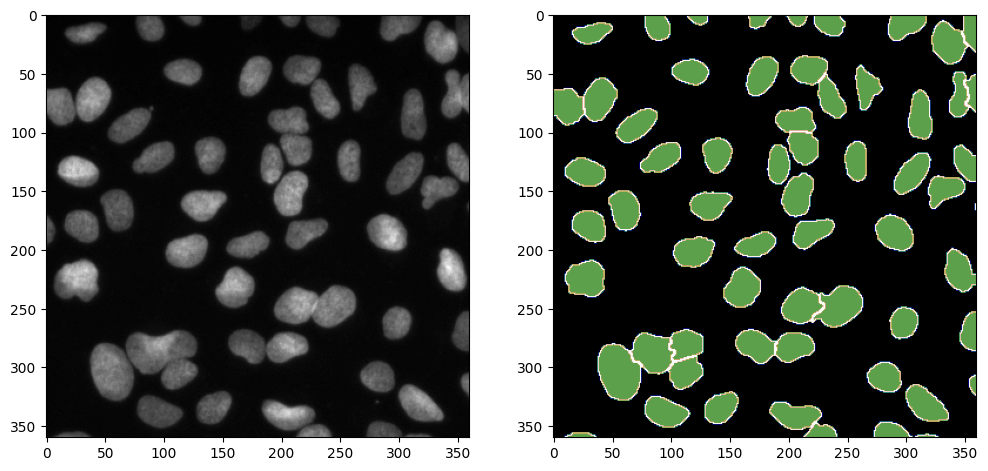

The shape of the dataset is: torch.Size([1, 360, 360])


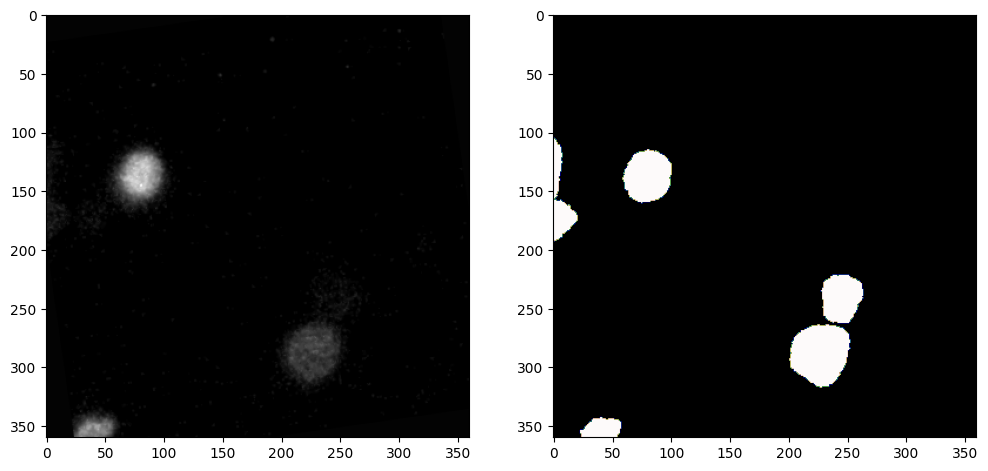

In [7]:
# lets look at our raw data
plot_random_image()

dataset = "dsb2018"
prediction_type = PredictionType.TWO_CLASS
num_fmaps_out = 2
dtype = torch.FloatTensor

# let's look at our data for the specific prediction type
tmp_data = KaggleDSB_dataset(dataset, mode="train", prediction_type=prediction_type)
tmp_loader = DataLoader(tmp_data, batch_size=1, shuffle=True)
print("The shape of the dataset is: {}".format(tmp_data[0][0].shape))

img_tmp, label_tmp = tmp_data[np.random.randint(0, len(tmp_data), 1)[0]]
plot_image(img_tmp, label_tmp, prediction_type=prediction_type)

# 1. (Effective) Receptive Field of View

We use the U-Net you implemented in your last task. But don't worry, we provide you with our implementation and you will build up on this.

The number of convolutions and the depth of the U-Net are the major factors in determining the
receptive field of the network. The term is borrowed from biology where it describes the "portion of sensory space that can elicit neuronal responses when stimulated" (wikipedia). Each output pixel can look at/depends on an input patch with that diameter centered at its position.
Based on this patch, the network has to be able to make a decision about the prediction for the respective pixel.
Yet larger sizes increase the computation time significantly.

This paper gives a short introduction into the computation: [What are the Receptive, Effective Receptive, and Projective Fields of Neurons in Convolutional Neural Networks?](https://arxiv.org/pdf/1705.07049.pdf).

For more detail you can look into [Computing Receptive Fields of Convolutional Neural Networks](https://distill.pub/2019/computing-receptive-fields/).

The effective receptive field of your network depends on the kind and number of layers.
Some layers have no impact on it, e.g. ReLu as it only works on individual pixels.
Some layers have a one-time effect on it, e.g. convolutional layers, as they work on a local patch of pixels.
A convolutional kernel with a size of 3 looks at the pixel itself and the direct neighbor on each side, it thus increases the receptive field by 2 (per dimension).
Some layers have a permanent effect on it, e.g. pooling. For example, 2x max-pooling (with a stride of two) reduces the image size by a factor of two and selects the maximum value of each block of size 2.
However, all following convolutional layers now operate on the pooled features.
Thus the pixels the kernel covers each correspond to two pixels from before the pooling layer.
A convolutional kernel with size 3 thus increases the receptive field not by 2 but by 2 * size of pooling layer * number of pooling layers before it.

Think about how the other layers in your network influence the field of view of your network.

Implement the get_fov function in our Unet implementation to compute the receptive field of your U-Net.

In [8]:
class FovUNet(UNet):
    """UNet with a field of view implementation."""

    def __init__(
            self,
            in_channels,
            num_fmaps,
            fmap_inc_factors,
            downsample_factors,
            kernel_size_down,
            kernel_size_up,
            activation,
            padding,
            num_fmaps_out,
            constant_upsample
    ):
        super(FovUNet, self).__init__(
            in_channels,
            num_fmaps,
            fmap_inc_factors,
            downsample_factors,
            kernel_size_down,
            kernel_size_up,
            activation,
            padding,
            num_fmaps_out,
            constant_upsample
        )
        # hint: you might need specifically these variables
        self.num_levels = len(downsample_factors) + 1
        self.kernel_size_down = kernel_size_down
        self.kernel_size_up = kernel_size_up
        self.downsample_factors = downsample_factors


    def get_fov(self):
        """Compute the receptive field of the Unet."""
        fov = np.array([0,0])

        ########################################################################
        # TODO: Field of View                                                  #
        # - Implement your Unet field of view function here                    #
        # - Hint: You can call and or define any other class functions         #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        fov = np.array([0,0])
        # Compute FOV through the upsampling path
        for i in range(self.num_levels - 1, 0, -1):
            print(f"Layer {i}")
            kernel = stride = np.array(self.kernel_size_up[i - 1])
            fov = fov + (kernel - 1) * stride
            print(f"after conv {fov=}")
            fov = fov // np.array(self.downsample_factors[i - 1])
            print(f"after pooling {fov=}")
            #stride = stride // np.array(self.downsample_factors[i])

        # Compute bottleneck
        kernel = stride = np.array(self.kernel_size_down[self.num_levels - 1])
        fov = fov + (kernel - 1) * stride
        print(f"after bottleneck {fov=}")

        # Compute FOV through the downsampling path
        for i in range(self.num_levels - 1, 0, -1):
            fov = fov * np.array(self.downsample_factors[i - 1])
            print(f"after pooling {fov=}")
            print(f"Layer {self.num_levels - i}")
            kernel = stride = np.array(self.kernel_size_down[i - 1])
            fov = fov + (kernel - 1) * stride
            print(f"after conv {fov=}")
        return fov

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return fov

### Vizualize the receptive field

Layer 4
after conv fov=array([[6, 6],
       [6, 6]])
after pooling fov=array([[3, 3],
       [3, 3]])
Layer 3
after conv fov=array([[9, 9],
       [9, 9]])
after pooling fov=array([[4, 4],
       [4, 4]])
Layer 2
after conv fov=array([[10, 10],
       [10, 10]])
after pooling fov=array([[5, 5],
       [5, 5]])
Layer 1
after conv fov=array([[11, 11],
       [11, 11]])
after pooling fov=array([[5, 5],
       [5, 5]])
after bottleneck fov=array([[11, 11],
       [11, 11]])
after pooling fov=array([[22, 22],
       [22, 22]])
Layer 1
after conv fov=array([[28, 28],
       [28, 28]])
after pooling fov=array([[56, 56],
       [56, 56]])
Layer 2
after conv fov=array([[62, 62],
       [62, 62]])
after pooling fov=array([[124, 124],
       [124, 124]])
Layer 3
after conv fov=array([[130, 130],
       [130, 130]])
after pooling fov=array([[260, 260],
       [260, 260]])
Layer 4
after conv fov=array([[266, 266],
       [266, 266]])
Receptive field size: [[266 266]
 [266 266]]


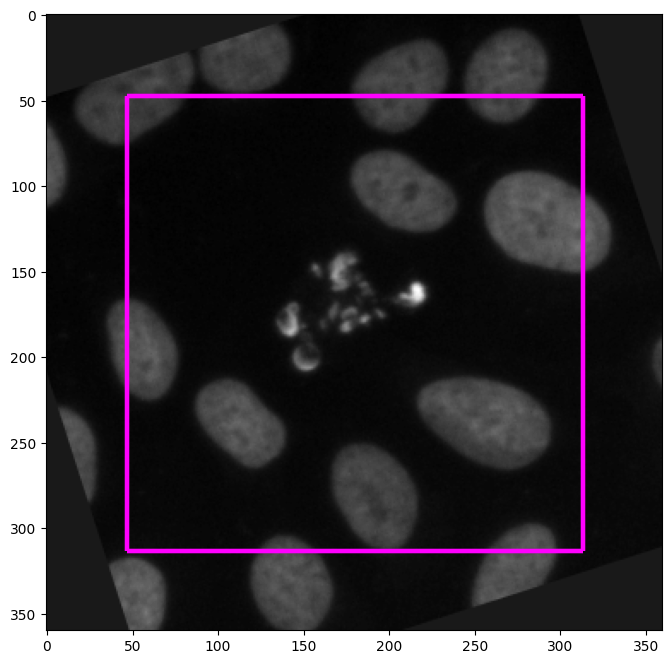

In [9]:
d_factors = [[2, 2], [2, 2], [2, 2], [2, 2]]

# initialize a small network
fov_unet = FovUNet(
    in_channels=1,
    num_fmaps=6,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='same',
    num_fmaps_out=6,
    constant_upsample=False,
    kernel_size_down=[[(3, 3), (3, 3)]] * (len(d_factors) + 1),
    kernel_size_up=[[(3, 3), (3, 3)]] * len(d_factors),
)
task_head = torch.nn.Conv2d(in_channels=6, out_channels=1, kernel_size=1, padding=0, bias=True)

net = torch.nn.Sequential(
    fov_unet,
    task_head
)

# visualize receptive field
dataiter = iter(tmp_loader)
inputs, labels = next(dataiter)

fov = net[0].get_fov()
print("Receptive field size: %s" % fov)

plot_receptive_field(inputs, fov)

## Question 1
Hypothesize shortly what receptive field sizes might make sense for the kaggle nuclei dataset and why?  
(The important part here is to think about it and come up with arguments for your theories.  
You get points even if your ideas don't apply in this case)  

################ START OF YOUR TEXT ################

Given that the nuclei are approximately of size 25 x 25 pixels, the receptive field size should be in the same ballpark. A receptive field size in the range of approximately 50x50 pixels should be effective. This size ensures that the network has a sufficiently large context to accurately identify and segment nuclei while not being too large to dilute the focus on individual nuclei.

################ END OF YOUR TEXT ################


# 5. Instance Segmentation

So far we were only interested in classes, what is background and foreground,
where are cells or person vs car. But in many cases we not only want to know
if a certain pixel belongs to a cell, but also to which cell.

For isolated objects, this is trivial, all connected foreground pixels form
one instance, yet often instances are very close together or even overlapping.
Then we need to think a bit more how to formulate the loss for our network
and how to extract the instances from the predictions.

## Instance segmentation approaches

There are many different approaches to instance segmentation.
We will introduce three basic methods:

### Three-class model
This is an extension of the basic foreground/background (or two-class) model.
In addition a third class is introduced: the boundary.
Even if two instances are touching, there is a boundary between them. This way they can be separated.
Instead of a single output (where an output of zero is one class and of one is the other class), the network outputs three values, one per class. And the loss function changes from binary to (sparse) categorical cross entropy.

![three_class.png](https://drive.google.com/uc?export=view&id=1ORZTlHXJHKNFLf9U-PVraCNKLLgD-UON)

### Distance Transform
The label for each pixel is the distance to the closest boundary.
The value within instances is negative and outside of instances is positive.
As the output is not a probability but an (in principle) unbounded scalar, the mean squared error loss function is used.

![sdt.png](https://drive.google.com/uc?export=view&id=1NucFhe9qWvj26A7R7BUQhCFsktDIZrYF)


### Edge Affinities
Here we consider not just the pixel but also its direct neighbors (in 2D the left neighbor and the upper neighbor are sufficient, right and down are redundant with the next pixel's left and upper neighbor).
Imagine there is an edge between two pixels if they are in the same class and no edge if not. If we then take all pixels that are directly and indirectly connected by edges, we get an instance. The network predicts the probability that there is an edge, this is called affinity.
As we are considering two neighbors per pixel, our network needs two outputs and as the output is a probability, we are using binary cross entropy

![affinities.png](https://drive.google.com/uc?export=view&id=1qRxqyFLmVqDx4EP4aQPaJbLZKsaV5OLq)

### Metric Learning
In metric learning your model learns to predict an embedding vector for each pixel. These embedding vectors are learned such that vectors from pixels belonging to the same instance are similar to each other and dissimilar to the embedding vectors of other instances and the background. It can also be thought of as learning a false coloring where each instance is colored with a unique but arbitrary color.  
![metric_learning.png](https://drive.google.com/uc?export=view&id=1ynjUUcsnADX2VltNg26RtQzLYl7S0cDQ)



## Activation and loss functions
We have 5 types of labels, corresponding to 5 **prediction_types** below.

For each case, we should define the corresponding output channel numbers, final activation layer, criterion(loss function) and dtye(the data type of the label).It would be clear to fill in these conditions after you look through the part of code about how we define training process.

Please fill in the missing code and uncomment one of the **prediction_type** to start your training. Please consider the discriminative loss from utils for the metric learning approach.

In [19]:
def get_instance_segmentation_types(prediction_type):
    from utils.disc_loss import DiscriminativeLoss
    from utils.disc_loss import FakeLoss
    ########################################################################
    # TODO: segmentation types                                             #
    # - Fill in the correct number of out_channels, activation,            #
    # loss function, and dtype for the PredictionType TWO_CLASS and        #
    # THREE_CLASS                                                          #
    ########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    if prediction_type == PredictionType.TWO_CLASS:
        out_channels = 2
        activation = torch.nn.Softmax(dim=1)
        loss_fn = torch.nn.CrossEntropyLoss()
        dtype = torch.FloatTensor
    elif prediction_type == PredictionType.THREE_CLASS:
        out_channels = 3
        activation = torch.nn.Softmax(dim=1)
        loss_fn = torch.nn.CrossEntropyLoss()
        dtype = torch.FloatTensor
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    elif prediction_type == PredictionType.AFFINITIES:
        out_channels = 2
        activation = torch.nn.Sigmoid()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        dtype = torch.FloatTensor
    elif prediction_type == PredictionType.SDT:
        out_channels = 1
        activation = None
        loss_fn = torch.nn.MSELoss()
        dtype = torch.FloatTensor
    elif prediction_type == PredictionType.METRIC_LEARNING:
        out_channels = 4
        activation = None
        loss_fn = DiscriminativeLoss(device=device)
        dtype = torch.FloatTensor
    else:
        raise RuntimeError("invalid prediction type")


    return out_channels, activation, loss_fn, dtype


In [20]:
########################################################################
# TODO (later) - first reach the evaluation task - evaluation:         #
# - enable different Prediction Types other than THREE_CLASS           #
#    and compare the evaluation performance                            #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# prediction_type = PredictionType.THREE_CLASS
# prediction_type = PredictionType.AFFINITIES
# prediction_type = PredictionType.SDT
# prediction_type = PredictionType.METRIC_LEARNING
prediction_type = PredictionType.TWO_CLASS
# prediction_type = PredictionType.THREE_CLASS

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

out_channels, activation, loss_fn, dtype = get_instance_segmentation_types(prediction_type)

## Define our U-Net for instance segmentation

As before, we define our neural network architecture and can choose the depth and number of feature maps at the first convolution.

In [21]:
d_factors = [[2, 2], [2, 2], [2, 2]]

unet = FovUNet(
    in_channels=1,
    num_fmaps=32,
    fmap_inc_factors=2,
    downsample_factors=d_factors,
    activation='ReLU',
    padding='valid',
    num_fmaps_out=32,
    constant_upsample=False,
    kernel_size_down=[[(3, 3), (3, 3)]] * (len(d_factors) + 1),
    kernel_size_up=[[(3, 3), (3, 3)]] * len(d_factors),
)

task_head = torch.nn.Conv2d(in_channels=32, out_channels=out_channels, kernel_size=1, padding=0, bias=True)

net = torch.nn.Sequential(
    unet,
    task_head
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

## Prepare the data for training

In [22]:
data_train = KaggleDSB_dataset(dataset, "train", prediction_type=prediction_type, padding_size=10)
data_val = KaggleDSB_dataset(dataset, "val", prediction_type=prediction_type, padding_size=10)
data_test = KaggleDSB_dataset(dataset, "test", prediction_type=prediction_type, padding_size=10)

# look at what the dataset returns
print('Train set size: {}'.format(len(data_train)))
print('Validation set size: {}'.format(len(data_val)))
print('Test set size: {}'.format(len(data_test)))
data_shape = data_train[0][0].shape
print('Data dimension after padding: {}'.format(data_shape))

Train set size: 30
Validation set size: 8
Test set size: 16
Data dimension after padding: torch.Size([1, 380, 380])


In [23]:
# check if your network produces the expected output
summary(net, data_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 378, 378]             320
              ReLU-2         [-1, 32, 378, 378]               0
            Conv2d-3         [-1, 32, 376, 376]           9,248
              ReLU-4         [-1, 32, 376, 376]               0
          ConvPass-5         [-1, 32, 376, 376]               0
         MaxPool2d-6         [-1, 32, 188, 188]               0
        Downsample-7         [-1, 32, 188, 188]               0
            Conv2d-8         [-1, 64, 186, 186]          18,496
              ReLU-9         [-1, 64, 186, 186]               0
           Conv2d-10         [-1, 64, 184, 184]          36,928
             ReLU-11         [-1, 64, 184, 184]               0
         ConvPass-12         [-1, 64, 184, 184]               0
        MaxPool2d-13           [-1, 64, 92, 92]               0
       Downsample-14           [-1, 64,

## Prepare the dataloader

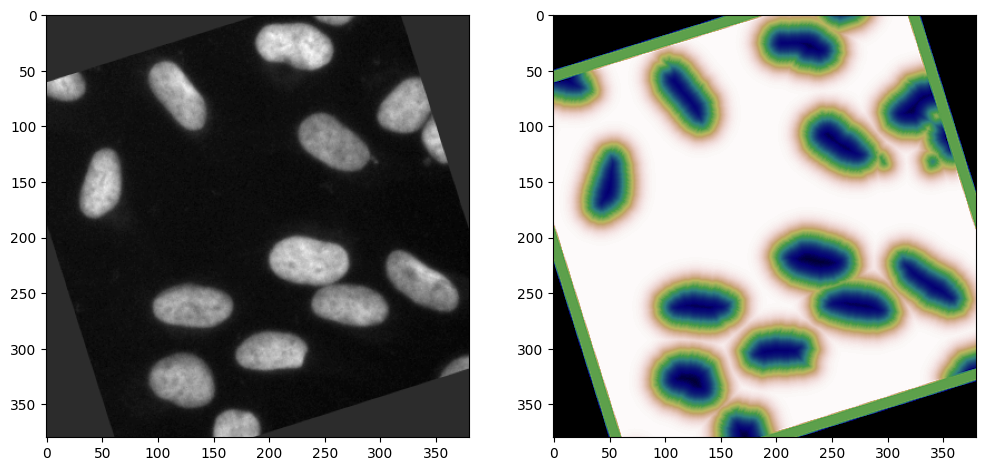

In [17]:
# re-define your dataloaders
batch_size = 4
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(data_val, batch_size=1, pin_memory=True)
test_loader = DataLoader(data_test, batch_size=1)

img_tmp, label_tmp = data_train[np.random.randint(0, len(data_train), 1)[0]]
plot_image(img_tmp, label_tmp, prediction_type=prediction_type)


## Train the instance segmentation network

Before we start training, we have to compile the network and set the optimizer (try playing with the learning rate, a higher learning rate can lead to faster training, but also to divergence or lower performance).

To visualize our results we now use Tensorboard. This is a very useful extension for your browser that let's you look into networks computational graph and the weights and metrics over time.

In [18]:
training_steps = 20  # feel free to change me
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss_fn = loss_fn.to(device)
# set optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# set flags
net.train()
loss_fn.train()
step = 0

step_train_val_routine(net, train_loader, val_loader, training_steps, optimizer, loss_fn, writer, prediction_type,
                       device, dtype=dtype)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

#or run:
#!tensorboard --logdir=runs
#to view in separate window

## Postprocessing

In contrast to the semantic segmentation the postprocessing to extract the final segmentation is a bit more involved and consists of x steps for the two class, three class, sdt and affinity models:
- based on the prediction we define a surface
- we extract the maxima from this surface
- we use the maxima as seeds in an off-the-shelf watershed algorithm
- and mask the result with the foreground.
The foreground areas covered by the watershed from each seed point correspond to the instances.
The resulting instances are then matched to the ground truth instances (at least 50% overlap) to get our final score (averaged over all instances and all test images)

For the metric learning model, the post-processing is a bit different. The embeddings are clustered with the mean shift algorithm and the clusters are numbered. You can think of this as clustering pixels by their color, such that the pixels that belong to one uniquely colored instance end up in one cluster and get the same number assigned.

## Class-intern benchmark
Try different methods, hyperparameters, padding,network sizes, etc. and see how you can improve your results. Write down your best average precision on the test set with the corresponding network settings.


################ START OF YOUR TEXT ################

################ END OF YOUR TEXT ################

-0.69446975 0.86114454
average precision: 0.8837209302325582, precision: 0.9743589743589743, recall: 0.9047619047619048
true positives: 38, false positives: 1, false negatives: 4


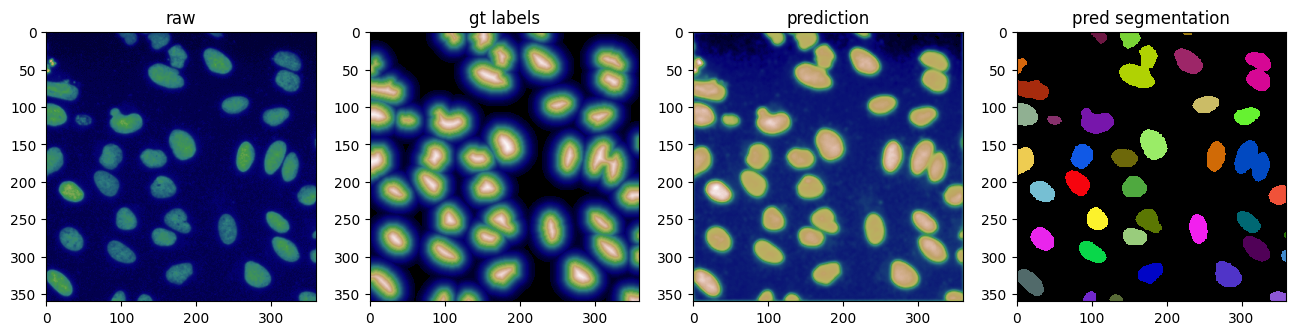

-0.69512254 1.4747524
average precision: 0.09836065573770492, precision: 0.4090909090909091, recall: 0.11464968152866242
true positives: 18, false positives: 26, false negatives: 139


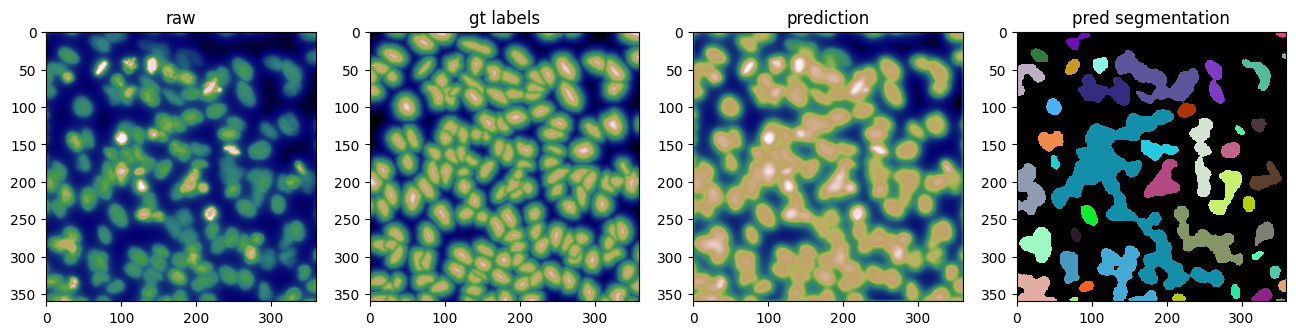

-0.6317197 0.95841163
average precision: 0.625, precision: 0.9090909090909091, recall: 0.6666666666666666
true positives: 20, false positives: 2, false negatives: 10


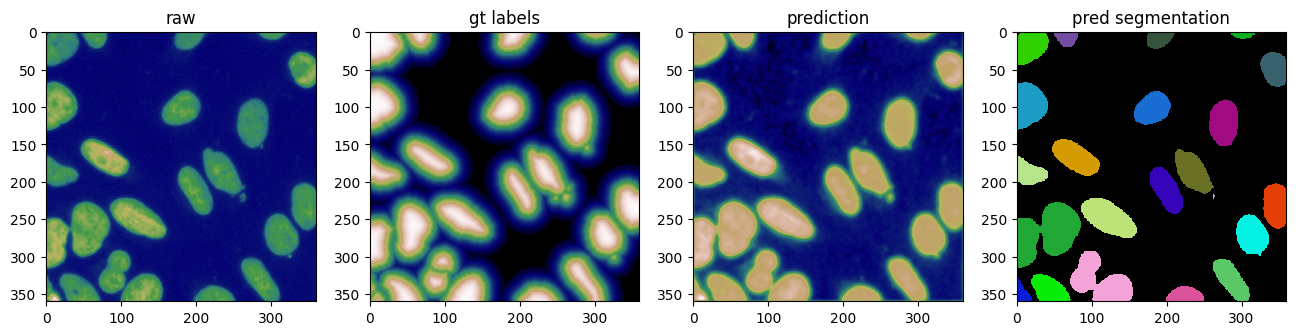

-0.8815447 0.8830539
average precision: 0.7962962962962963, precision: 0.9347826086956522, recall: 0.8431372549019608
true positives: 43, false positives: 3, false negatives: 8


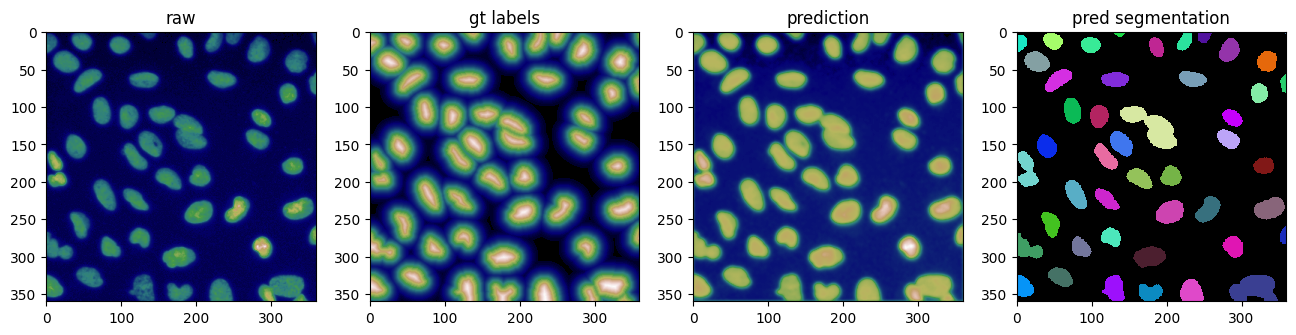

-0.635492 0.8548504
average precision: 0.7391304347826086, precision: 0.9444444444444444, recall: 0.7727272727272727
true positives: 17, false positives: 1, false negatives: 5


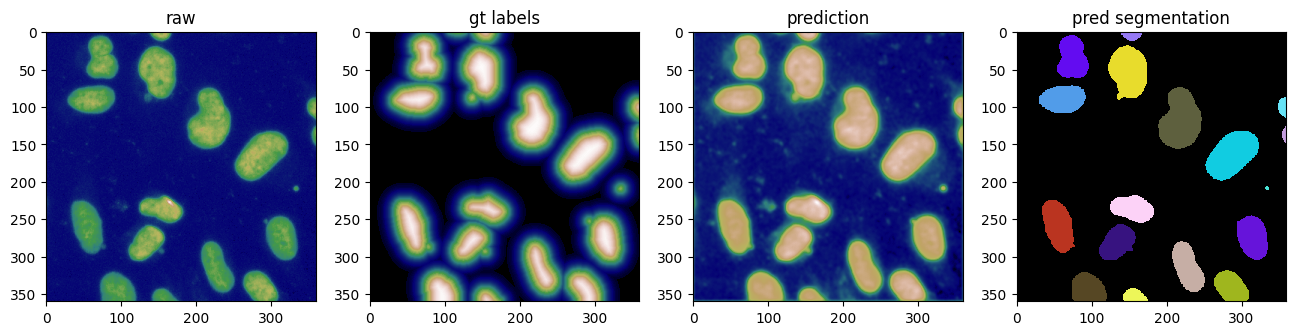

-0.70576054 0.9054905
average precision: 0.85, precision: 1.0, recall: 0.85
true positives: 17, false positives: 0, false negatives: 3


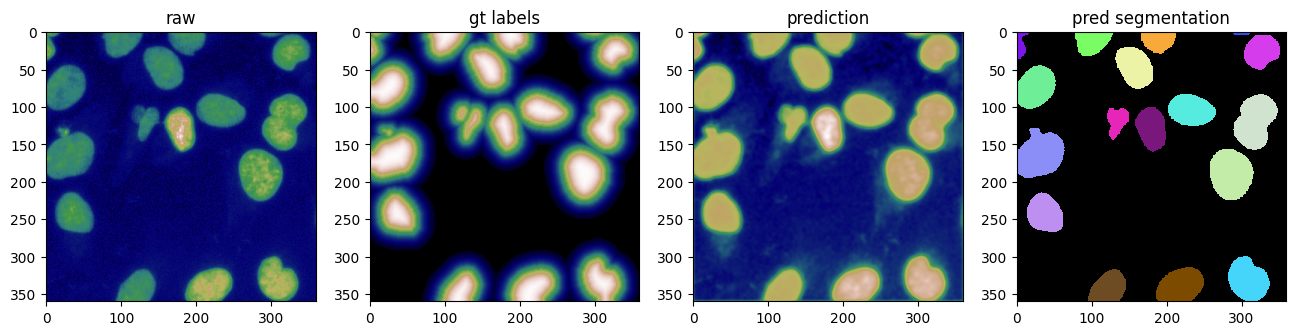

-0.46812373 1.1293527
average precision: 0.7142857142857143, precision: 0.8823529411764706, recall: 0.7894736842105263
true positives: 15, false positives: 2, false negatives: 4


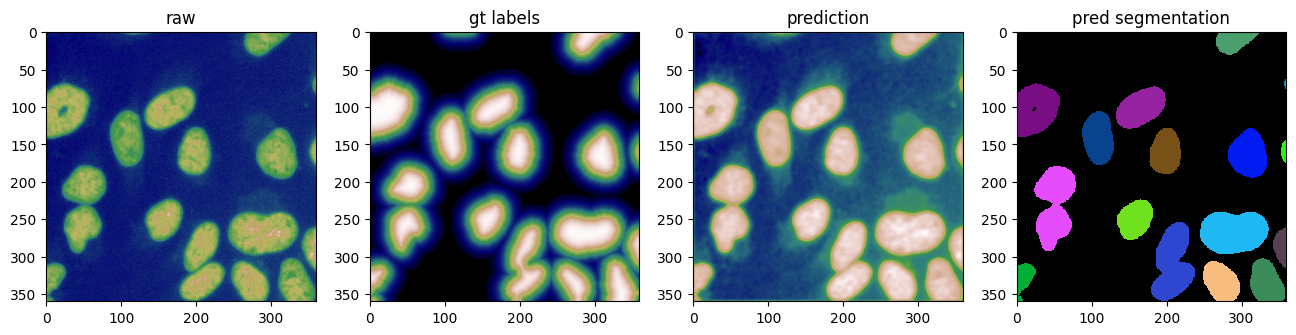

-1.3491539 0.58159226
average precision: 0.0, precision: 0.0, recall: 0.0
true positives: 0, false positives: 7, false negatives: 7


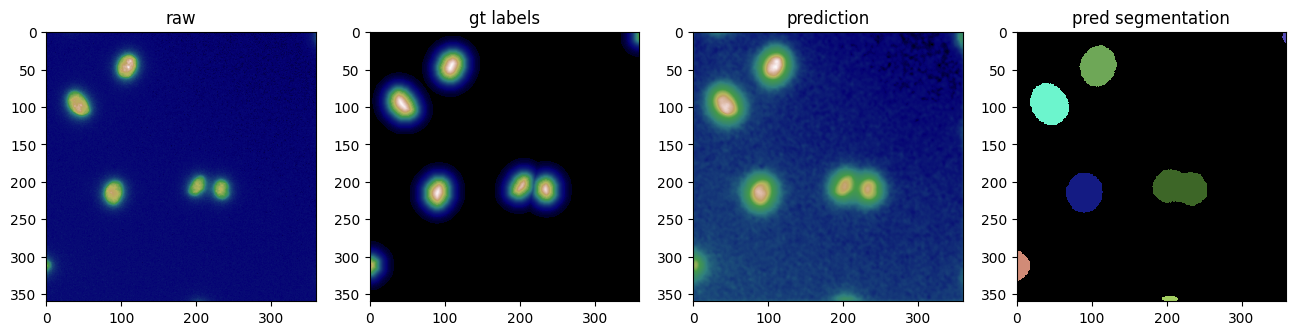

-0.70537615 0.7723831
average precision: 0.45454545454545453, precision: 0.7692307692307693, recall: 0.5263157894736842
true positives: 10, false positives: 3, false negatives: 9


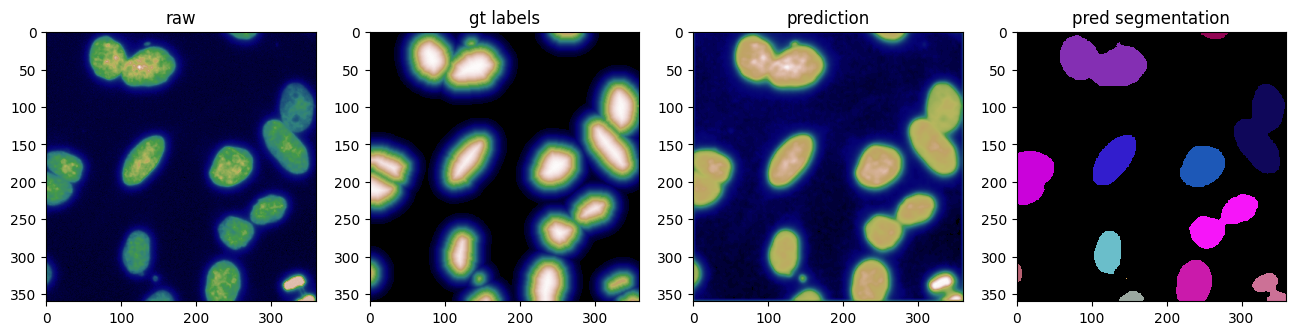

-0.873201 0.90807647
average precision: 0.5873015873015873, precision: 0.8222222222222222, recall: 0.6727272727272727
true positives: 37, false positives: 8, false negatives: 18


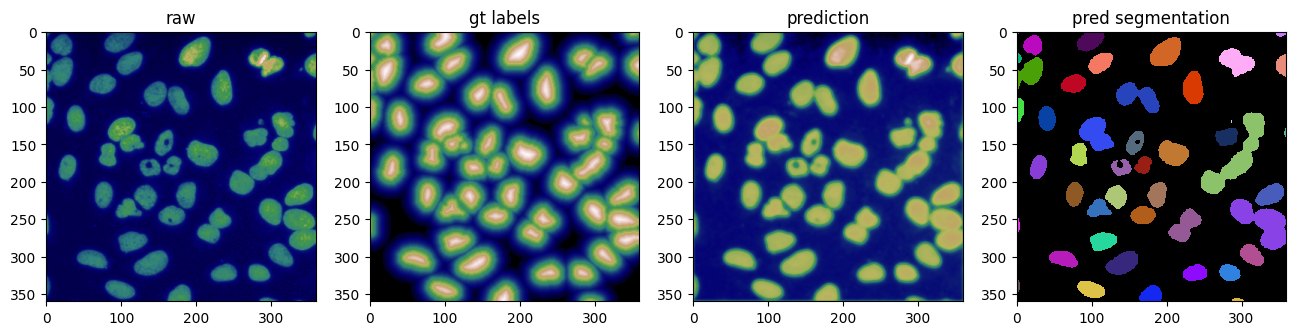

-0.82666624 0.7314733
average precision: 0.75, precision: 1.0, recall: 0.75
true positives: 12, false positives: 0, false negatives: 4


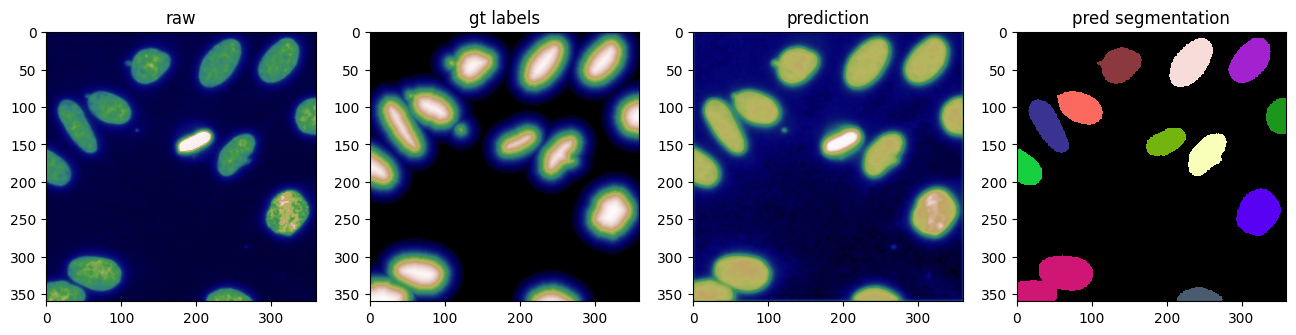

-0.8475337 0.74704
average precision: 0.7333333333333333, precision: 0.8461538461538461, recall: 0.8461538461538461
true positives: 22, false positives: 4, false negatives: 4


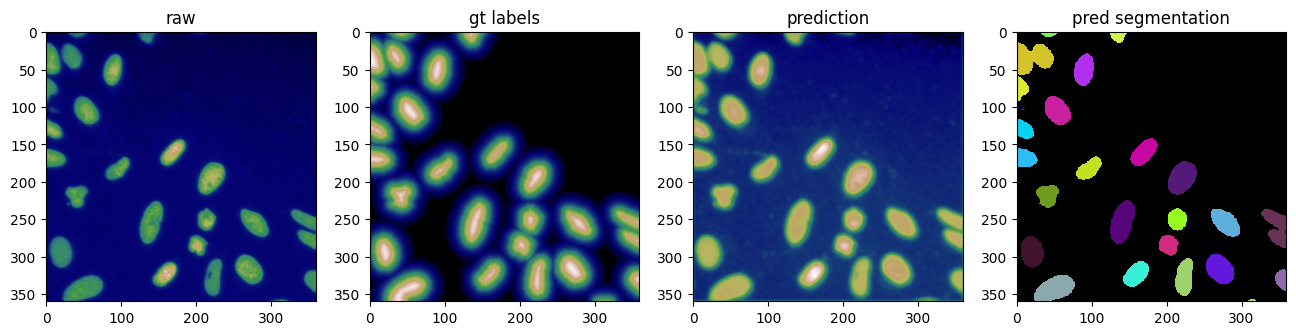

-1.1727023 0.57965255
average precision: 0.6923076923076923, precision: 0.9, recall: 0.75
true positives: 9, false positives: 1, false negatives: 3


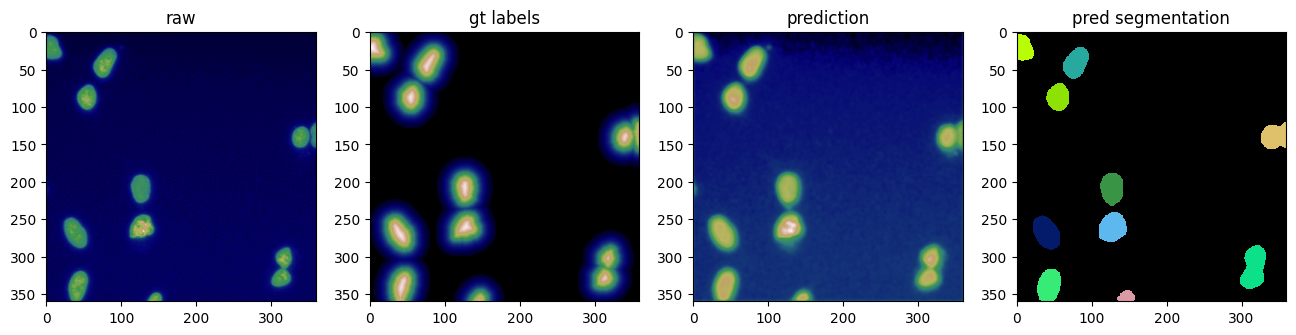

-0.51739633 1.0666342
average precision: 0.85, precision: 1.0, recall: 0.85
true positives: 17, false positives: 0, false negatives: 3


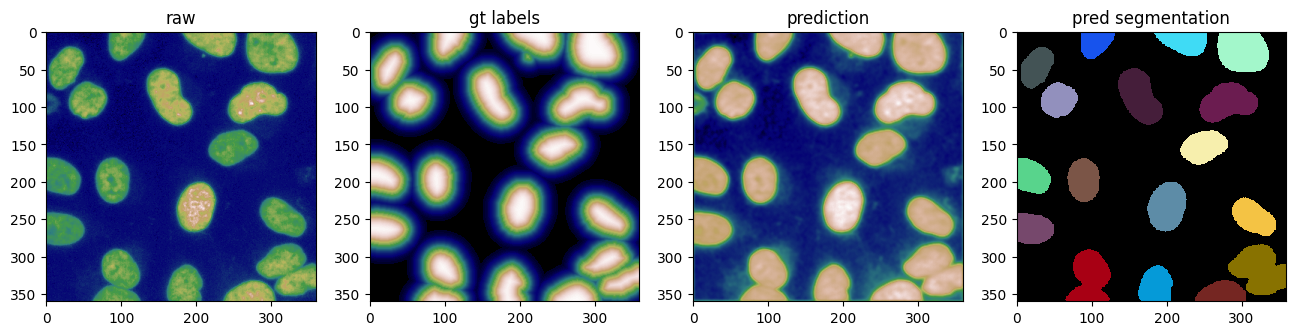

-1.2431579 0.7904975
average precision: 0.95, precision: 1.0, recall: 0.95
true positives: 38, false positives: 0, false negatives: 2


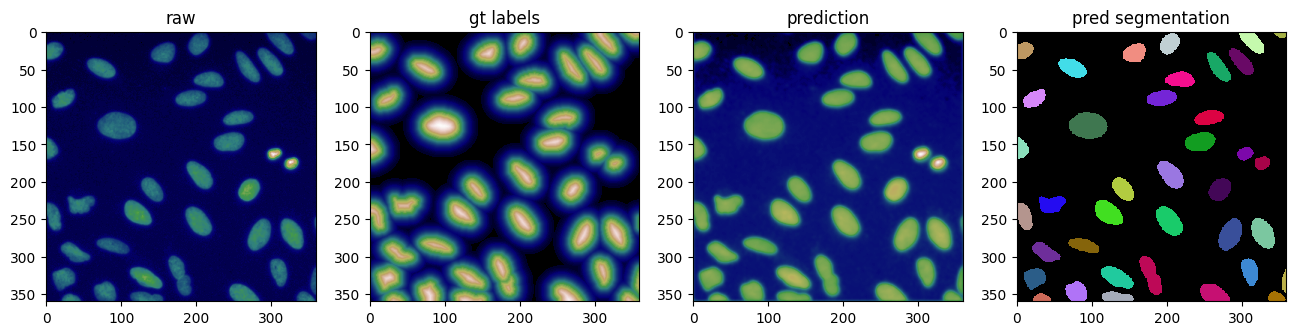

-0.47715867 1.0816053
average precision: 0.7916666666666666, precision: 0.95, recall: 0.8260869565217391
true positives: 19, false positives: 1, false negatives: 4


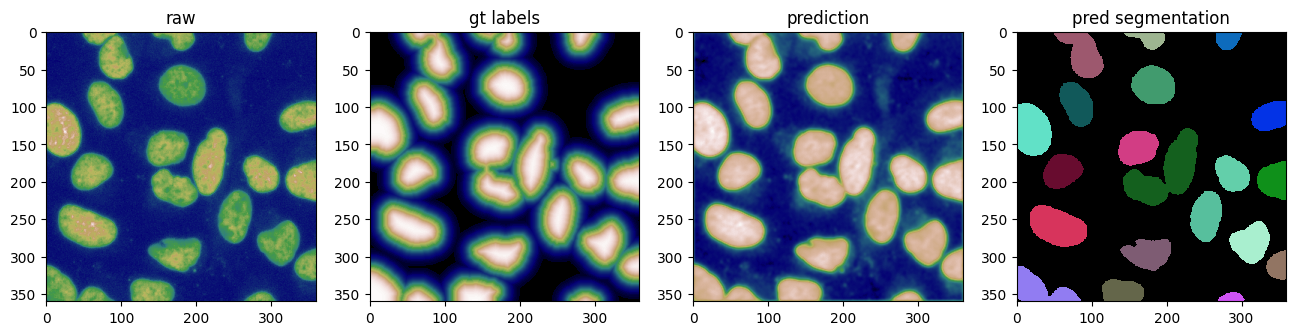

average precision on test set: 0.6572467978431009


In [ ]:

########################################################################
# TODO: evaluation                                                     #
# - Tune the thresholds of the preprocessing routine for               #
# each prediction type                                                 #
########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# thresholds have to be tuned after training on the validation set
if prediction_type == PredictionType.TWO_CLASS:
    fg_thresh = 0.5
    seed_thresh = 0.5
elif prediction_type == PredictionType.THREE_CLASS:
    fg_thresh = 0.5
    seed_thresh = 0.5
elif prediction_type == PredictionType.SDT:
    fg_thresh = 0.0
    seed_thresh = 0
elif prediction_type == PredictionType.AFFINITIES:
    fg_thresh = 0.5
    seed_thresh = 0.5
elif prediction_type == PredictionType.METRIC_LEARNING:
    fg_thresh = 0.5
    seed_thresh = None
else:
    raise ValueError("Unknown prediction type")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

test_evaluation_routine(net, test_loader, device, prediction_type, fg_thresh, seed_thresh, 10, data_test)

## Question 2

Do you have further ideas how to improve our instance segmentation approach (e.g. with changes regarding to the architecture, loss, etc.)?


################ START OF YOUR TEXT ################

################ END OF YOUR TEXT ################